In [96]:
%matplotlib inline
import os
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

keep the columns for median household income, median white household income, median black household income and median 
25-44 year olds income (since this is the group use divvy the most often)for each census tract

In [97]:
income = pd.read_csv ('ACS_15_5YR_S1903/ACS_15_5YR_S1903_with_ann.csv', usecols = [2, 5, 9, 13, 49])

In [98]:
#rename the column names and drop the first line
income.rename(columns={'GEO.display-label': 'Census Tract', 
                       'HC02_EST_VC02': 'HHD Median Income', 
                        'HC02_EST_VC04': 'White HHD Median Income',
                        'HC02_EST_VC05': 'Black HHD Median Income',
                        'HC02_EST_VC17': 'Age 25-44 HHD Median Income'}, inplace=True)
income = income.iloc[1:]

In [99]:
#only keep cook county in Illinois
il_income = income[income["Census Tract"].str.contains("Illinois")]
cook_income = il_income[il_income["Census Tract"].str.contains("Cook")]

In [100]:
#only keep census tract number; delete irrelevant strings under census tract column
cook_income["Census Tract"] = cook_income["Census Tract"].apply(lambda x: x.split(',')[0].split(' ')[-1])

/Applications/anaconda/envs/py-geo/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [101]:
cols = cook_income.columns.drop('Census Tract')
cook_income[cols] = cook_income[cols].apply(pd.to_numeric, errors='coerce')

/Applications/anaconda/envs/py-geo/lib/python3.6/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [102]:
cook_income = cook_income.set_index('Census Tract')

In [103]:
cook_income.head()

,HHD Median Income,White HHD Median Income,Black HHD Median Income,Age 25-44 HHD Median Income
Census Tract,,,,
101,32188.0,65104.0,22529.0,NaN
102.01,39122.0,51421.0,29779.0,41292.0
102.02,27318.0,50326.0,23224.0,NaN
103,37111.0,39985.0,23895.0,NaN
104,38384.0,45669.0,35114.0,45030.0


Now we clean demographic data by census tract. This data is stored in a shapefile

In [104]:
demo = gpd.read_file("Tract_2010Census_DP1/Tract_2010Census_DP1.shp")
demo.rename(columns = {"NAMELSAD10" : "Census Tract"}, inplace = True)

In [105]:
#clean census tract number and set as index
demo["Census Tract"] = demo["Census Tract"].apply(lambda x: x.split(' ')[-1])

In [106]:
#select the columns that are relevant for this project's purpose
demo = demo[['Census Tract','DP0020002', 'DP0020003', 'DP0030002', 'DP0030003', 'DP0080003', 
                         'DP0080004','DP0130002', 'DP0190001', 'DP0200001']]

In [107]:
#rename the columns
demo.columns = ["Census Tract","Male Median Age", "Female Median Age", "Male Pop over 16", "Female Pop over 16", "Total White Pop",
               "Total Black Pop", "No. of Family HHD", "Homeowner Vacancy Rate", "Rental Vacancy Rate"]

In [108]:
demo = demo.groupby('Census Tract', as_index=True).mean()
demo.head()

,Male Median Age,Female Median Age,Male Pop over 16,Female Pop over 16,Total White Pop,Total Black Pop,No. of Family HHD,Homeowner Vacancy Rate,Rental Vacancy Rate
Census Tract,,,,,,,,,
1,38.829341,40.227246,1434.416168,1384.637725,2604.637725,388.583832,837.649701,3.474251,9.704192
1.01,39.100000,41.289474,1775.105263,1832.824561,3564.368421,406.350877,1128.438596,4.487719,10.554386
1.02,39.300000,41.031148,1643.901639,1685.704918,3336.590164,334.508197,1075.803279,3.168852,8.818033
1.03,34.840000,36.490000,1641.000000,1732.150000,3263.100000,465.400000,1147.700000,3.085000,7.285000
1.04,32.900000,35.708333,1577.250000,1736.750000,3227.833333,203.000000,1072.083333,2.141667,5.908333


Now we merge demographic data with income data. Right now demographic data contains census tracts all over the US, we only want to keep those in cook county (i.e. the ones included in the income data)

In [109]:
socio_econ = pd.merge(cook_income, demo, right_index=True, left_index=True)

In [110]:
socio_econ.head()

,HHD Median Income,White HHD Median Income,Black HHD Median Income,Age 25-44 HHD Median Income,Male Median Age,Female Median Age,Male Pop over 16,Female Pop over 16,Total White Pop,Total Black Pop,No. of Family HHD,Homeowner Vacancy Rate,Rental Vacancy Rate
Census Tract,,,,,,,,,,,,,
101,32188.0,65104.0,22529.0,NaN,38.426190,40.269048,1692.315476,1737.690476,3532.869048,437.333333,1117.839286,2.398214,9.171429
102.01,39122.0,51421.0,29779.0,41292.0,36.940323,38.453226,1856.064516,1955.274194,3858.967742,605.629032,1237.741935,2.441935,8.751613
102.02,27318.0,50326.0,23224.0,NaN,37.723529,39.188235,2061.666667,2002.529412,4203.960784,535.117647,1344.039216,2.288235,9.103922
103,37111.0,39985.0,23895.0,NaN,37.508235,39.830588,1678.023529,1755.400000,3445.476471,507.164706,1095.676471,2.489412,9.281176
104,38384.0,45669.0,35114.0,45030.0,37.710778,40.259281,1666.035928,1764.592814,3333.598802,541.305389,1072.598802,2.339521,9.128743


Now the final step before we do any regression analysis is to merge in the number of divvy stations of each census tract in cook county.

By spatial join, we can map the coordinates of different divvy bike stations onto census tract

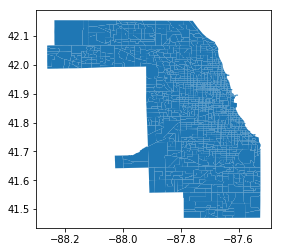

In [111]:
tract_df = gpd.read_file("cb_2014_17_tract_500k/cb_2014_17_tract_500k.shp")
tract_df = tract_df[tract_df["COUNTYFP"] == "031"]
tract_df.rename(columns = {"NAME" : "Census Tract"}, inplace = True) #rename Name as census tract

tract_df.plot()

In [112]:
divvy_df = pd.read_csv("Divvy_Bicycle_Stations_-_All_-_Map.csv", usecols = [6, 7])
divvy_df.dropna(inplace = True)

In [113]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(divvy_df.Longitude, divvy_df.Latitude)]
divvy_coords = gpd.GeoDataFrame(divvy_df, crs = {'init': 'epsg:4269'}, geometry=geometry)

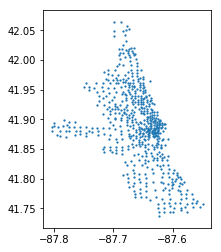

In [115]:
divvy_coords.plot(markersize = 1.5)

In [116]:
located_divvy = gpd.sjoin(divvy_coords, tract_df, how = 'left', op = 'within')
located_divvy.head()

,Latitude,Longitude,geometry,index_right,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,Census Tract,LSAD,ALAND,AWATER
0,41.858086,-87.651073,POINT (-87.651073 41.858086),902.0,17,031,310300,1400000US17031310300,17031310300,3103,CT,318223.0,0.0
1,41.880422,-87.642746,POINT (-87.642746 41.880422),722.0,17,031,281900,1400000US17031281900,17031281900,2819,CT,439082.0,0.0
2,41.900363,-87.696704,POINT (-87.696704 41.900363),855.0,17,031,242600,1400000US17031242600,17031242600,2426,CT,475743.0,0.0
3,41.867227,-87.625961,POINT (-87.625961 41.867227),2112.0,17,031,330100,1400000US17031330100,17031330100,3301,CT,2793984.0,828956.0
4,41.885041,-87.612794,POINT (-87.61279399999999 41.88504099999999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
divvy_tract_count = located_divvy.groupby("Census Tract").count()
divvy_tract_count = divvy_tract_count[["index_right"]].rename(columns = {"index_right" : "Number of Divvy Station"})
divvy_tract_count.sort_values(by = "Number of Divvy Station", ascending = False)

,Number of Divvy Station
Census Tract,
8391,17
8419,10
3301,10
3201,9
818,7
8330,7
8422,6
8439,5
2819,5


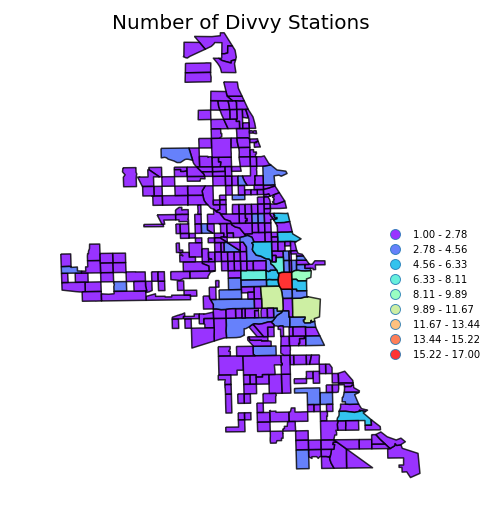

In [118]:
mapped_divvy = pd.merge(tract_df, divvy_tract_count, how = "inner", left_on = "Census Tract", right_index = True) #preserve the census tract geometry
ax = mapped_divvy.plot(column = "Number of Divvy Station", cmap = "rainbow", scheme = "equal_interval", k = 9, legend = True,
                 alpha = 0.8, linewidth = 1.5, edgecolor = "black", figsize = (9, 9))


ax.set_title("Number of Divvy Stations", fontsize = 20, y = 0.95)
ax.set_axis_off()

ax.get_legend().set_bbox_to_anchor((1.13, 0.57))   
ax.get_legend().get_frame().set_linewidth(0)

fig = ax.get_figure()
fig.savefig("Divvy_Station_Map.png")

Merge total number of divvy stations in each census tract to socio economic factors of each census tract

In [119]:
divvy_socio = pd.merge(divvy_tract_count, socio_econ, right_index=True, left_index=True)

In [120]:
divvy_socio.head()

,Number of Divvy Station,HHD Median Income,White HHD Median Income,Black HHD Median Income,Age 25-44 HHD Median Income,Male Median Age,Female Median Age,Male Pop over 16,Female Pop over 16,Total White Pop,Total Black Pop,No. of Family HHD,Homeowner Vacancy Rate,Rental Vacancy Rate
Census Tract,,,,,,,,,,,,,,
101,1,32188.0,65104.0,22529.0,NaN,38.426190,40.269048,1692.315476,1737.690476,3532.869048,437.333333,1117.839286,2.398214,9.171429
102.01,2,39122.0,51421.0,29779.0,41292.0,36.940323,38.453226,1856.064516,1955.274194,3858.967742,605.629032,1237.741935,2.441935,8.751613
102.02,2,27318.0,50326.0,23224.0,NaN,37.723529,39.188235,2061.666667,2002.529412,4203.960784,535.117647,1344.039216,2.288235,9.103922
103,1,37111.0,39985.0,23895.0,NaN,37.508235,39.830588,1678.023529,1755.400000,3445.476471,507.164706,1095.676471,2.489412,9.281176
104,1,38384.0,45669.0,35114.0,45030.0,37.710778,40.259281,1666.035928,1764.592814,3333.598802,541.305389,1072.598802,2.339521,9.128743


The Question is, what drives the variation? In order to see the correlation between number of divvy station and neighborhood characterisitcs, we do regression analysis

In [121]:
from scipy import stats
from statsmodels import api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.mixed_linear_model as sm_mlm

from time import sleep

In [122]:
divvy_socio.columns = [c.replace(' ', '_') for c in divvy_socio.columns]
divvy_socio.head()

,Number_of_Divvy_Station,HHD_Median_Income,White_HHD_Median_Income,Black_HHD_Median_Income,Age_25-44_HHD_Median_Income,Male_Median_Age,Female_Median_Age,Male_Pop_over_16,Female_Pop_over_16,Total_White_Pop,Total_Black_Pop,No._of_Family_HHD,Homeowner_Vacancy_Rate,Rental_Vacancy_Rate
Census Tract,,,,,,,,,,,,,,
101,1,32188.0,65104.0,22529.0,NaN,38.426190,40.269048,1692.315476,1737.690476,3532.869048,437.333333,1117.839286,2.398214,9.171429
102.01,2,39122.0,51421.0,29779.0,41292.0,36.940323,38.453226,1856.064516,1955.274194,3858.967742,605.629032,1237.741935,2.441935,8.751613
102.02,2,27318.0,50326.0,23224.0,NaN,37.723529,39.188235,2061.666667,2002.529412,4203.960784,535.117647,1344.039216,2.288235,9.103922
103,1,37111.0,39985.0,23895.0,NaN,37.508235,39.830588,1678.023529,1755.400000,3445.476471,507.164706,1095.676471,2.489412,9.281176
104,1,38384.0,45669.0,35114.0,45030.0,37.710778,40.259281,1666.035928,1764.592814,3333.598802,541.305389,1072.598802,2.339521,9.128743


Test Model

In [123]:
ols_1 = smf.ols(formula = "N ~ I",
              data = divvy_socio.rename(columns = {"Number_of_Divvy_Station" : "N", 
                                          "HHD_Median_Income"  : "I"}))
model_1 = ols_1.fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      N   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     19.17
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           1.61e-05
Time:                        17:10:00   Log-Likelihood:                -599.52
No. Observations:                 331   AIC:                             1203.
Df Residuals:                     329   BIC:                             1211.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1036      0.169      6.525      0.000       0.771       1.436
I           1.135e-05   2.59e-06      4.379      0.000    6.25e-06    1.64e-05
==============================================================================
Omnibus:                      364.062   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19279.644
Skew:                           4.746   Prob(JB):                         0.00
Kurtosis:                      39.164   Cond. No.                     1.35e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Even though the coefficient on median income is significant, the R-squared is pretty low right now. we can improve the model by including more relevant factors as explanatory variables. Also, we notice the coefficient is so small that is inconvenient to read so we re-scale income as in thousands of dollars. 

In [124]:
divvy_socio['HHD_Median_Income'] = divvy_socio['HHD_Median_Income']/1000
divvy_socio['White_HHD_Median_Income'] = divvy_socio['White_HHD_Median_Income']/1000
divvy_socio['Black_HHD_Median_Income'] = divvy_socio['Black_HHD_Median_Income']/1000
divvy_socio['Age_25-44_HHD_Median_Income'] = divvy_socio['Age_25-44_HHD_Median_Income']/1000

Previously, we have seen user behavior variations between males and females, now from a macro level, we want to see if number of divvy stations vary according to the male/female composition of the neighborhood. Indeed, it makes sense to for divvy to set up stations in neighborhoods where more males are living. 

A distinctive characteristic of chicago is that white black population composition vary a lot from one zipcode to another so we want to take this factor into account as well. 

A lot of working professionals use divvy bikes for the last mile. Home vacancy is ususally a good proxy for how populated one area is. 

In [125]:
ols_2 = smf.ols(formula = "N ~ I + W_I + B_I + M_age + F_age + N_Fam + V + R_V",
              data = divvy_socio.rename(columns = {"Number_of_Divvy_Station" : "N", 
                                          "HHD_Median_Income"  : "I",
                                         "White_HHD_Median_Income": "W_I",
                                         "Black_HHD_Median_Income": "B_I",
                                        "Male_Median_Age": "M_age",
                                        "Female_Median_Age": "F_age", 
                                        "No._of_Family_HHD": "N_Fam",
                                        "Homeowner_Vacancy_Rate": "V",
                                        "Rental_Vacancy_Rate": "R_V"}))
model_2 = ols_2.fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      N   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     3.842
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           0.000412
Time:                        17:10:14   Log-Likelihood:                -264.47
No. Observations:                 148   AIC:                             546.9
Df Residuals:                     139   BIC:                             573.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0783      1.278      0.844      0.400      -1.449       3.605
I              0.0072      0.008      0.909      0.365      -0.008       0.023
W_I            0.0101      0.006      1.656      0.100      -0.002       0.022
B_I            0.0055      0.005      1.148      0.253      -0.004       0.015
M_age          0.1530      0.075      2.038      0.043       0.005       0.301
F_age         -0.1812      0.072     -2.526      0.013      -0.323      -0.039
N_Fam          0.0006      0.000      1.132      0.260      -0.000       0.002
V              0.0284      0.031      0.925      0.357      -0.032       0.089
R_V            0.0159      0.042      0.380      0.705      -0.067       0.099
==============================================================================
Omnibus:                       86.474   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              414.505
Skew:                           2.179   Prob(JB):                     9.80e-91
Kurtosis:                       9.944   Cond. No.                     1.04e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Out of all the variables included, the ones with relatively significant coefficients are: White Median Income, Male Median Age, Female Median Age. We discuss the interpretations one by one

White median income: 0.0101. Significant at 90% confidence interval. When the median income for whites increase by 100(k), on average there is one more divvy bike station in that neighborhood. 

Male Median Age: 0.15. As male median age increase by one, divvy station is expected to increase by 0.15. Whis is the same as saying, male median age increase by around 7 years, on average there should be one more divvy station in the neighborhood. It is not hard to realize that divvy is not designed for the elders so maybe there is decline in divvy station after we reach a certain point. so we will include a quadratic term for age in the next round of regression

As a comparison, Female Median Age: -0.18. Highly significant. As female median age increase by one, divvy station is expected to DECREASE by 0.18. Whis is the same as saying, female median age increase by around 5 years, on average there should be one FEWER divvy station in the neighborhood. 

Next we add in the quadratic term age and number of people over 16 living in that neighborhood



# Non-Linear Least Squares

In [126]:
divvy_socio['M_Age_Sqr'] = divvy_socio.Male_Median_Age ** 2 
divvy_socio['F_Age_Sqr'] = divvy_socio.Female_Median_Age ** 2 


ols_3 = smf.ols(formula = "N ~ I + W_I + B_I + M_age + M_Age_Sqr + F_age + F_Age_Sqr + M_pop + F_pop + N_Fam + V + R_V",
              data = divvy_socio.rename(columns = {"Number_of_Divvy_Station" : "N", 
                                          "HHD_Median_Income"  : "I",
                                         "White_HHD_Median_Income": "W_I",
                                         "Black_HHD_Median_Income": "B_I",
                                        "Male_Median_Age": "M_age",
                                        "Female_Median_Age": "F_age", 
                                        "M_Age_Sqr": "M_Age_Sqr",
                                        "F_Age_Sqr": "F_Age_Sqr",
                                        "Male_Pop_over_16": "M_pop",
                                        "Female_Pop_over_16": "F_pop", 
                                        "No._of_Family_HHD": "N_Fam",
                                        "Homeowner_Vacancy_Rate": "V",
                                        "Rental_Vacancy_Rate": "R_V"}))
model_3 = ols_3.fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      N   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     5.424
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           1.81e-07
Time:                        17:10:27   Log-Likelihood:                -250.14
No. Observations:                 148   AIC:                             526.3
Df Residuals:                     135   BIC:                             565.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2735      5.956     -0.214      0.831     -13.052      10.505
I              0.0033      0.007      0.445      0.657      -0.011       0.018
W_I            0.0099      0.006      1.738      0.085      -0.001       0.021
B_I            0.0005      0.005      0.101      0.920      -0.009       0.009
M_age          0.7121      0.542      1.314      0.191      -0.360       1.784
M_Age_Sqr     -0.0090      0.008     -1.197      0.233      -0.024       0.006
F_age         -0.6369      0.504     -1.264      0.209      -1.634       0.360
F_Age_Sqr      0.0080      0.007      1.203      0.231      -0.005       0.021
M_pop          0.0018      0.001      1.612      0.109      -0.000       0.004
F_pop          0.0007      0.001      0.648      0.518      -0.001       0.003
N_Fam         -0.0031      0.001     -3.217      0.002      -0.005      -0.001
V              0.0284      0.029      0.993      0.322      -0.028       0.085
R_V           -0.0111      0.039     -0.282      0.778      -0.089       0.067
==============================================================================
Omnibus:                       95.052   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              546.785
Skew:                           2.362   Prob(JB):                    1.85e-119
Kurtosis:                      11.146   Cond. No.                     1.68e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With this model, we get the best fitting model with R -squared value 0.325. 
Variables significant: White median income, Male population over 16. Number of Families. 
interpretations for the first two do not change much Number of families is an interesting one:
we notice number of families increase by 1000, divvy station number decrease by 3. Maybe from this, we could say divvy is not so family friendly since it is true that families are more likely to have cars. if people have cars, they do not really use divvy bike. 

Although the coefficients on age and age squared are not significant, it is still interesting to interpret.

For male: 0.7121/(2*-0.009) = 39. Which suggests, before age 39, the bigger the median male age, the more divvy station. but after age 39, the relationship is no longer positive. Which makes sense according to our summary of statistics on users. not many people over age 44 use divvy bikes anyway

For Female: (-0.6369)/(2*0.008) = 39! very interesting right? before 39, the bigger the median female age, the fewer divvy station in their neighborhood. after 39, the bigger the median female age, the more divvy stations. 

Male age and female age have exactly the opposite relationship to divvy stations in their neighborhood! 
Why? we have a few hypothesis but unfortunately due to the limited scope of this project, we are unable to test any of them below

1) it could be after 39 years old, women have kids who are old enough to use divvy bikes
2) it could be behavioral differences among males and females: younger males are more prone to innovations and new tools versus elders females are drawn to this type of things

..........


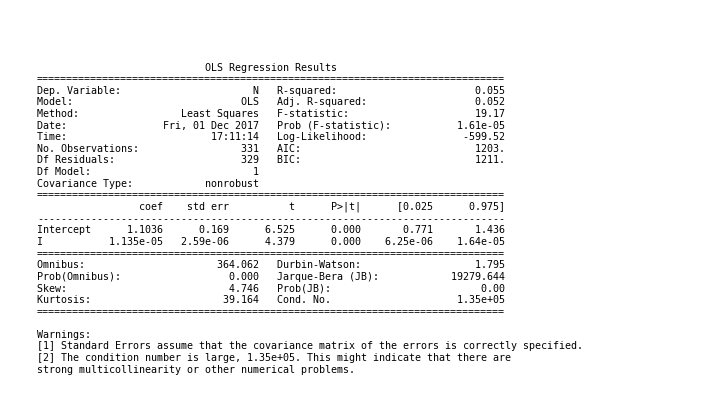

In [127]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))


plt.text(0.01, 0.05, str(model_1.summary()), {'fontsize': 15}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')

plt.savefig('baseline_ols.png', bbox_inches = 'tight')

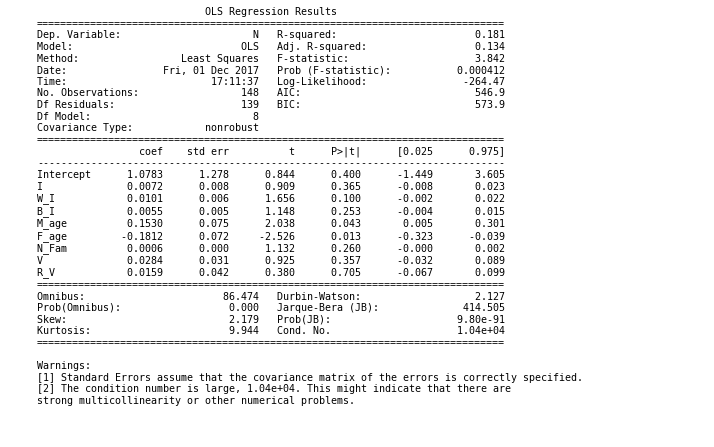

In [128]:
plt.text(0.01, 0.05, str(model_2.summary()), {'fontsize': 15}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.savefig('better_ols.png', bbox_inches = 'tight')

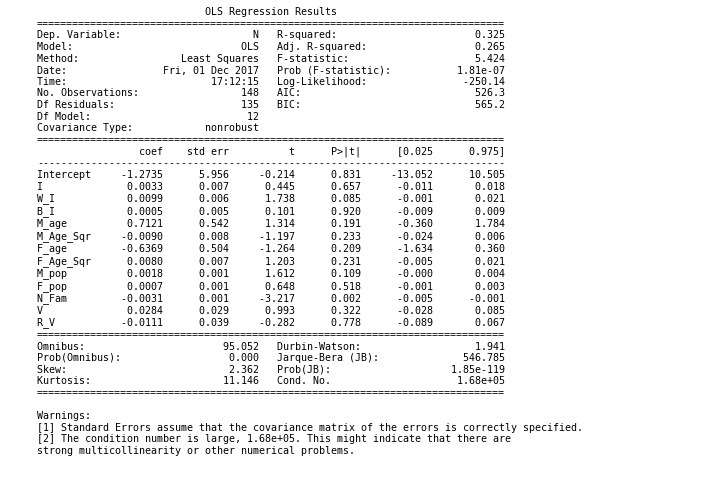

In [129]:
plt.text(0.01, 0.05, str(model_3.summary()), {'fontsize': 15}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.savefig('nonlinear_ols.png', bbox_inches = 'tight')

## Non-Linear Model: The Likelihood of Having Divvy


Previously, when we did the analysis for number of divvy stations in each census tract, we simply omit those without divvy stations at all.

Now we change the question a little bit by asking what socio economic factors determine whether the neighborhood have divvy service or not. 


first, we need to get those neighborhoods without divvy back into our dataset

In [130]:
divvy_socio_1 = socio_econ.join(divvy_tract_count)

Create a dummy variable "divvy" indicating whether that neighborhood has divvy service or not

In [131]:
divvy_socio_1['Divvy'] = (divvy_socio_1['Number of Divvy Station'] > 0).astype(int)

divvy_socio_1.head()

,HHD Median Income,White HHD Median Income,Black HHD Median Income,Age 25-44 HHD Median Income,Male Median Age,Female Median Age,Male Pop over 16,Female Pop over 16,Total White Pop,Total Black Pop,No. of Family HHD,Homeowner Vacancy Rate,Rental Vacancy Rate,Number of Divvy Station,Divvy
Census Tract,,,,,,,,,,,,,,,
101,32188.0,65104.0,22529.0,NaN,38.426190,40.269048,1692.315476,1737.690476,3532.869048,437.333333,1117.839286,2.398214,9.171429,1.0,1
102.01,39122.0,51421.0,29779.0,41292.0,36.940323,38.453226,1856.064516,1955.274194,3858.967742,605.629032,1237.741935,2.441935,8.751613,2.0,1
102.02,27318.0,50326.0,23224.0,NaN,37.723529,39.188235,2061.666667,2002.529412,4203.960784,535.117647,1344.039216,2.288235,9.103922,2.0,1
103,37111.0,39985.0,23895.0,NaN,37.508235,39.830588,1678.023529,1755.400000,3445.476471,507.164706,1095.676471,2.489412,9.281176,1.0,1
104,38384.0,45669.0,35114.0,45030.0,37.710778,40.259281,1666.035928,1764.592814,3333.598802,541.305389,1072.598802,2.339521,9.128743,1.0,1


Now we run a logit model

In [132]:
divvy_socio_1.columns = [c.replace(' ', '_') for c in divvy_socio_1.columns]
divvy_socio_1.head()

,HHD_Median_Income,White_HHD_Median_Income,Black_HHD_Median_Income,Age_25-44_HHD_Median_Income,Male_Median_Age,Female_Median_Age,Male_Pop_over_16,Female_Pop_over_16,Total_White_Pop,Total_Black_Pop,No._of_Family_HHD,Homeowner_Vacancy_Rate,Rental_Vacancy_Rate,Number_of_Divvy_Station,Divvy
Census Tract,,,,,,,,,,,,,,,
101,32188.0,65104.0,22529.0,NaN,38.426190,40.269048,1692.315476,1737.690476,3532.869048,437.333333,1117.839286,2.398214,9.171429,1.0,1
102.01,39122.0,51421.0,29779.0,41292.0,36.940323,38.453226,1856.064516,1955.274194,3858.967742,605.629032,1237.741935,2.441935,8.751613,2.0,1
102.02,27318.0,50326.0,23224.0,NaN,37.723529,39.188235,2061.666667,2002.529412,4203.960784,535.117647,1344.039216,2.288235,9.103922,2.0,1
103,37111.0,39985.0,23895.0,NaN,37.508235,39.830588,1678.023529,1755.400000,3445.476471,507.164706,1095.676471,2.489412,9.281176,1.0,1
104,38384.0,45669.0,35114.0,45030.0,37.710778,40.259281,1666.035928,1764.592814,3333.598802,541.305389,1072.598802,2.339521,9.128743,1.0,1


In [133]:
from statsmodels.formula.api import logit, probit, poisson, ols

prob_mod = logit("Divvy ~ HHD_Median_Income + White_HHD_Median_Income + Black_HHD_Median_Income + Male_Median_Age"
                 "+ Male_Pop_over_16 + Female_Median_Age+ Female_Pop_over_16" 
                   , divvy_socio_1).fit()

print(prob_mod.summary())

Optimization terminated successfully.
         Current function value: 0.518865
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Divvy   No. Observations:                  522
Model:                          Logit   Df Residuals:                      514
Method:                           MLE   Df Model:                            7
Date:                Fri, 01 Dec 2017   Pseudo R-squ.:                  0.1298
Time:                        17:12:33   Log-Likelihood:                -270.85
converged:                       True   LL-Null:                       -311.24
                                        LLR p-value:                 9.499e-15
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.2155      0.940     -1.293      0.196      -3.057   

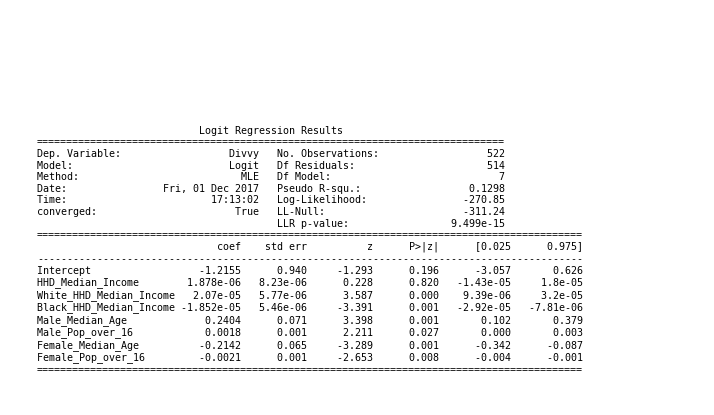

In [134]:
plt.text(0.01, 0.05, str(prob_mod.summary()), {'fontsize': 15}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')

plt.savefig('logit.png', bbox_inches = 'tight')

All of the variables, except median household income are significant!